Code for Kaggle competition: Predict Future Sales.

References:
- https://www.coursera.org/learn/competitive-data-science/home/welcome
-  https://www.kaggle.com/dlarionov/feature-engineering-xgboost

# Importing Packages:

In [138]:

import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline 

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import lightgbm
from xgboost import XGBRegressor


# Loading Data

In [47]:
DATA_FOLDER = './data/predict-future-sales/'

In [48]:
sales = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
sample = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))

Converting dates to datetime:

In [49]:
sales['date'] = pd.to_datetime(sales.date, format='%d.%m.%Y')

# EDA and Data Processing

## Outliers

The sales dataframe contains daily information about sales (quantity and price) by store and item. Date_block_num is just a conveninece and tells which month the data point belongs to (there are 34 months on the dataset and we want to forecast sales on the 35th month). There are no missing values on this dataset and the types are all numeric.

In [50]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [51]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [52]:
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

We see some extreme values for item_cnt_day:

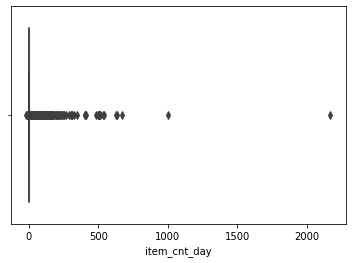

In [53]:
sns.boxplot(x=sales['item_cnt_day']);

Taking a closer look on the most extreme value, we see that the item_price for that sale is much smaller than the other days. There must be something wrong with this data entry and we will remove it.

In [54]:
sales[sales['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [55]:
sales[sales['item_id'] == 11373].sort_values(by='item_cnt_day').tail(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2608326,2015-04-14,27,12,11373,711.688525,61.0
2865335,2015-09-29,32,12,11373,152.353846,65.0
2144606,2014-11-13,22,12,11373,159.952381,84.0
2731649,2015-07-06,30,12,11373,98.947368,95.0
1651754,2014-05-27,16,12,11373,214.134021,97.0
1058343,2013-11-29,10,12,11373,72.200000,105.0
2608348,2015-04-16,27,12,11373,120.120370,108.0
1058340,2013-11-22,10,12,11373,102.466942,242.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [56]:
sales = sales[sales['item_cnt_day'] <= 1000]

There is a price more than five times higher than the other entries on the dataset:

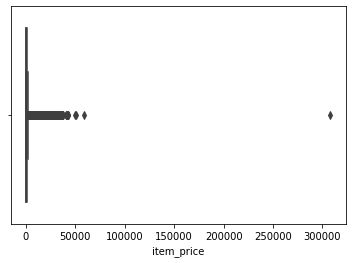

In [57]:
sns.boxplot(sales['item_price'])

There is only one very expensive sale for what seems to be some kind of software (using google translator). We will remove this entry as well.

In [58]:
sales[sales['item_price']>250000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [59]:
sales[sales['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [60]:
items[items['item_id']==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [61]:
item_categories[item_categories['item_category_id'] == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


In [62]:
sales = sales[sales['item_price'] < 250000]

## Any Repeated Entries

Let's check for repeated entries (two different item or shop number for the same item/store):

In [63]:
items['item_name'].shape[0] == items['item_name'].nunique()

True

In [64]:
item_categories.shape[0] == item_categories['item_category_name'].nunique()

True

In [65]:
shops.shape[0] == shops['shop_name'].nunique()

True

Everything seems to be ok. One note here: one of the kernels on Kaggle adjusts for repeated shop names. Looking at the data, 3 pairs of shops in the dataset appear to be similar, with small spelling difference. Since I do not know Russian, I couldn't be sure that those stores were indeed different.

## Processing strings

Very useful information from the discussion kernels: the first name on shop_name represents the city and item_category_name contains type and subtype. Let's check a few entries with google translator:

In [66]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Якутск = Yakutsk and Адыгея = Adygea, both Russian cities. For some reason, some of the names have an exclamation mark. Let's remove these and process the new information:

In [67]:
clean_shop_names = [shop_name[1:] if shop_name[0]=='!' else shop_name for shop_name in shops['shop_name']]
shops['shop_name'] = clean_shop_names

In [68]:
city_names = [shop_name.split(' ')[0] for shop_name in clean_shop_names]
shops['city'] = city_names
shops['city'] = LabelEncoder().fit_transform(shops['city'])

In [69]:
shops.drop(columns='shop_name', inplace=True)

In [70]:
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


Now processing item_category:

In [71]:
item_categories['category'] = [word.split('-')[0].strip() for word in item_categories['item_category_name']]
item_categories['category'] = LabelEncoder().fit_transform(item_categories['category'])

In [72]:
item_categories['sub_category'] = [word.split('-')[1].strip() if len(word.split('-')) > 1 else 'None' for word in item_categories['item_category_name']]
item_categories['sub_category'] = LabelEncoder().fit_transform(item_categories['sub_category'])

In [73]:
item_categories.drop(columns='item_category_name', inplace=True)

In [74]:
item_categories.head()

,item_category_id,category,sub_category
0,0,0,29
1,1,1,10
2,2,1,11
3,3,1,12
4,4,1,14


We will not use any information from item_name for now, so we drop it:

In [75]:
items.drop(columns='item_name', inplace=True)

In [76]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [77]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Monthly Data

Some item-shop combinations from the test set are not present on the training set. To deal with this, we will start by making a grid with all possible shop-item-month combinations from the training set:

In [78]:
from itertools import product

grid = []

for month in sales['date_block_num'].unique():
    
    shop_ids = sales.loc[sales['date_block_num'] == month, 'shop_id'].unique()
    item_ids = sales.loc[sales['date_block_num'] == month, 'item_id'].unique()
    grid.append(np.array(list(product(shop_ids, item_ids, [month]))))

In [79]:
col_names = ['shop_id', 'item_id', 'date_block_num']
grid_df = pd.DataFrame(np.vstack(grid), columns = col_names)

We will aggregate our data on a monthly frequency on top of this new grid. When data is not available for a certain month-item-shop combination, it means that there are no sales for that item on that shop for that month, so we fill these positions with 0.

## Target (month-shop-item agreggation)

Let's start with the target variable aggregation, that is the sum os sales count for every month-store-item combination:

In [80]:
sales_gb = sales.groupby(['date_block_num', 'shop_id', 'item_id'])

In [81]:
# it drops the date column automatically for sum and mean
agg_sales = sales_gb.agg(
    {
     'item_cnt_day':[np.sum]
    }
).fillna(0).clip(0,20)

In [82]:
agg_sales.columns = ['target']

In [83]:
monthly_sales = pd.merge(grid_df, agg_sales, how='left', on=col_names)

According to the competition rules, the final predictions should be clipped between 0 and 20. We clip our data as well, so we can optimize our models will the test set in mind:

In [84]:
monthly_sales['target'] = monthly_sales['target'].fillna(0).clip(0,20)

# Merging Train and Test Set:

On the next section, we will create new features (from target mean encoding and using lags). We will also need to create these new features on the test set, so we can use our model to predict on the final set and submit the results. By merging our training data and the test set, we can create the new features on both sets in one single pass. We will be careful to avoid data leakage. First, we add the new columns created so far on the test set:

In [85]:
test_mod = test[['shop_id', 'item_id']].copy()
test_mod['date_block_num'] = 34
test_mod['target'] = np.nan

Then we concatenate the data:

In [86]:
data = pd.concat([monthly_sales, 
                  test_mod], axis=0)

# New Features

## City and Category Information

First, we need the item_category IDs:

In [87]:
data = pd.merge(data, items, 
                         how='left', on=['item_id'])

Now we add category and sub_category:

In [88]:
data = pd.merge(data, item_categories, how='left',
         on=['item_category_id'])

Finally, we add city:

In [89]:
data = pd.merge(data, shops, how='left',
                         on=['shop_id'])

In [90]:
data.tail()

,shop_id,item_id,date_block_num,target,item_category_id,category,sub_category,city
11127999,45,18454,34,NaN,55,13,2,20
11128000,45,16188,34,NaN,64,14,40,20
11128001,45,15757,34,NaN,55,13,2,20
11128002,45,19648,34,NaN,40,11,4,20
11128003,45,969,34,NaN,37,11,1,20


## Target Mean Encoding

In this section, we add target mean encoded variables, using several combinations of features for the aggregations. We won't worry about using KFold scheme to calculate the mean encoded variables because we will only use lags of these, so there is no data leakage.

In [91]:
def add_target_encoding(data, join_on, name, y_name='target'):
    
    data_agg = data.groupby(join_on).agg({y_name:['mean']})
    data_agg.columns = [name]

    return pd.merge(data, data_agg, on=join_on)
    

Month:

In [92]:
data = add_target_encoding(data,['date_block_num'], 'target_month')

Month-item:

In [93]:
data = add_target_encoding(data,['date_block_num', 'item_id'], 
                           'target_month_item')

Month-shop:

In [94]:
data = add_target_encoding(data,['date_block_num', 'shop_id'], 
                           'target_month_shop')

Month-Item_Category_Id:

In [95]:
data = add_target_encoding(data,['date_block_num', 'item_category_id'], 
                           'target_month_item_category_id')

Month-shop-item_category_id:

In [96]:
data = add_target_encoding(data,['date_block_num', 'shop_id', 'item_category_id'], 
                           'target_month_shop_item_category_id')

Month-shop-category:

In [97]:
data = add_target_encoding(data,['date_block_num', 'shop_id', 'category'], 
                           'target_month_shop_category')

Month-shop-sub_category:

In [98]:
data = add_target_encoding(data,['date_block_num', 'shop_id', 'sub_category'], 
                           'target_month_shop_sub_category')

Month-City:

In [99]:
data = add_target_encoding(data,['date_block_num', 'city'], 
                           'target_month_city')

Month-Item-City:

In [100]:
data = add_target_encoding(data,['date_block_num','item_id', 'city'], 
                           'target_month_item_city')

Month-Category:

In [101]:
data = add_target_encoding(data,['date_block_num',  'category'], 
                           'target_month_category')

Month-Sub_category:

In [102]:
data = add_target_encoding(data,['date_block_num',  'sub_category'], 
                           'target_month_sub_category')

# Memory Management

The datasets are huge on this project. Let's free some memory to avoid any problems on the next steps.

Saving memory by convertin integers:

In [103]:
small_int_columns = ['city', 'item_category_id', 'category', 'sub_category',
                     'date_block_num', 'shop_id']

In [104]:
for col in small_int_columns:
    data[col] = data[col].astype(np.int16)

Same with floats:

In [105]:
# columns with target information. these will need to be removed before training
target_columns = [col for col in data.columns if col.startswith('target')]

In [106]:
for col in target_columns:
    data[col] = data[col].astype(np.float32)

Deleting data that we won't need from now on:

In [107]:
del sales, test, monthly_sales, test_mod
gc.collect()

2838

# Lags

Adding lags from the features that we created on the last section.

https://stackoverflow.com/questions/52693482/merging-pandas-data-frames-uses-way-too-much-memory

In [108]:
def lag_features(df, lags, group_cols, shift_col):
    """
    Arguments:
        df (pd.DataFrame)
        lags (list((int)): the number of months to lag by
        group_cols (list(str)): the list of columns that need to be the merged key
        shift_col (str): the column name that is to be shifted by
    """

    for lag in lags:
        new_col = '{0}_lag_{1}'.format(shift_col, lag)
        df[new_col] = df.groupby(group_cols)[shift_col].shift(lag)

    return df

## Features with Several Lags:

Target, Target-Month-Shop and Target-Month-Item:

In [109]:
lags = [1, 2, 3, 6, 12]
group_cols = ['shop_id', 'item_id']
order_col = 'date_block_num'

data = data.sort_values(by=group_cols+[order_col], ascending=True)
data = lag_features(data, lags, group_cols, 'target')

In [110]:
data = lag_features(data, lags, group_cols, 'target_month_item')

In [111]:
data = lag_features(data, lags, group_cols, 'target_month_shop')

## Features with One Lag:

For all the other mean-encoded features, we will use one lag only:

In [112]:
one_lag_columns = [col for col in target_columns if col not in ['target', 'target_month_item', 'target_month_shop']]

In [113]:
for col in one_lag_columns:
    data = lag_features(data, [1], group_cols, col)

Removing data from before month 12 (we only have data for all lags starting from month 13):

In [114]:
data = data[data['date_block_num'] >= 12]

In [115]:
y = data[['target', 'date_block_num']]

Dropping columns with mean-encoding (to avoid data leakage):

In [116]:
data.drop(columns=target_columns, inplace=True)

In [117]:
gc.collect()

20

There are a lot o NA's on the lags (remember, not every store sells every item every month, for example). We fill these with 0 (no sales for that combination on the corresponding lag).

In [118]:
data = data.fillna(0)

# Train/Validation/Test splits

We do a time series split in this case: last month is the test set, the one before will be used for validation and everything else will be used on model training:

In [119]:
X_train = data.loc[data['date_block_num'] <= 32].drop(columns=['date_block_num'])
X_valid = data.loc[data['date_block_num'] == 33].drop(columns=['date_block_num'])
X_test = data.loc[data['date_block_num'] == 34].drop(columns=['date_block_num'])

y_train = y.loc[y['date_block_num'] <= 32, 'target'].values
y_valid = y.loc[y['date_block_num'] == 33, 'target'].values

# Models

We start with two models: linear regression and lightgbm.

## Linear Model

We do the linear regression without regularization. This model is simply a benchmark and we expect it adds some value on the model stacking (next section).

In [120]:
lr = LinearRegression()

In [121]:
# remember to scale data when adding regularization
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [122]:
y_valid_predict_lr = lr.predict(X_valid).clip(0, 20)

In [123]:
np.sqrt(np.mean((y_valid_predict_lr - y_valid.clip(0, 20))**2))

0.9672958583526293

## LightGBM

Now the lightgbm model:

In [124]:
lgb_params = { 'max_depth':5,
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 40,
               'bagging_freq':1,
               'verbose':0 
              }

In [125]:
dtrain = lightgbm.Dataset(X_train, label=y_train.clip(0,20))
dvalid = lightgbm.Dataset(X_valid, label=y_valid.clip(0,20))

In [126]:
eval_results = {}

In [127]:
model = lightgbm.train(lgb_params,
                       dtrain,
                       valid_sets=[dtrain,dvalid],
                       valid_names=['train', 'valid'],
                       evals_result=eval_results,
                       num_boost_round=200,
                       early_stopping_rounds=10,
                       verbose_eval=True)

[1]	train's rmse: 1.17424	valid's rmse: 1.12638
Training until validation scores don't improve for 10 rounds
[2]	train's rmse: 1.16233	valid's rmse: 1.1183
[3]	train's rmse: 1.15084	valid's rmse: 1.11012
[4]	train's rmse: 1.13911	valid's rmse: 1.10196
[5]	train's rmse: 1.1271	valid's rmse: 1.09348
[6]	train's rmse: 1.1157	valid's rmse: 1.08547
[7]	train's rmse: 1.10482	valid's rmse: 1.07792
[8]	train's rmse: 1.09449	valid's rmse: 1.07067
[9]	train's rmse: 1.0847	valid's rmse: 1.06385
[10]	train's rmse: 1.07545	valid's rmse: 1.05759
[11]	train's rmse: 1.06729	valid's rmse: 1.05218
[12]	train's rmse: 1.05864	valid's rmse: 1.04639
[13]	train's rmse: 1.05053	valid's rmse: 1.04107
[14]	train's rmse: 1.04312	valid's rmse: 1.03621
[15]	train's rmse: 1.0357	valid's rmse: 1.03142
[16]	train's rmse: 1.02868	valid's rmse: 1.02694
[17]	train's rmse: 1.02201	valid's rmse: 1.02262
[18]	train's rmse: 1.01594	valid's rmse: 1.01868
[19]	train's rmse: 1.00991	valid's rmse: 1.01478
[20]	train's rmse: 1.0

Performance improves:

In [130]:
y_valid_predict_lgbm = model.predict(X_valid).clip(0, 20)

In [131]:
np.sqrt(np.mean((y_valid_predict_lgbm - y_valid.clip(0, 20))**2))

0.9472926793913473

# Stacking

Let's try using stacking to see if this improve our performance. We get the dates for train, validation, and test set. These will be useful for computations.

In [132]:
dates_train = data.loc[data['date_block_num'] <= 32, 'date_block_num']
dates_valid = data.loc[data['date_block_num'] == 33, 'date_block_num']
dates_test = data.loc[data['date_block_num'] == 34, 'date_block_num']

## Validation meta-features:

Calculating the validation meta-features:

In [133]:
pred_lr = lr.predict(X_valid.fillna(0)).clip(0,20)

In [134]:
pred_lgb = model.predict(X_valid).clip(0, 20)

In [135]:
X_valid_level2 = np.c_[pred_lr, pred_lgb]

## Train meta-features:

Train meta-features using times series scheme:

In [136]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])].clip(0,20)

In [137]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
y_train_with_index = pd.Series(data=y_train, index=X_train.index)

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    train_indeces = dates_train[dates_train < cur_block_num].index
    valid_indeces = dates_train[dates_train == cur_block_num].index 
    
    cur_X_train = X_train.loc[train_indeces]
    cur_y_train = y_train_with_index.loc[train_indeces]
    
    lr.fit(cur_X_train.fillna(0), cur_y_train)
    model = lightgbm.train(lgb_params, lightgbm.Dataset(cur_X_train, 
                                              label=cur_y_train), 100)
    
    cur_X_valid = X_train.loc[valid_indeces]
    
     
    X_train_level2[np.where(dates_train_level2==cur_block_num) , 0] = lr.predict(cur_X_valid.fillna(0)).clip(0,20)
    X_train_level2[np.where(dates_train_level2==cur_block_num) , 1] = model.predict(cur_X_valid).clip(0,20)

27
28
29
30
31
32


## Simple Convex Mix

Let's find an optimal alpha for a convex mix using the training set and evaluate performance on the validation set:

In [179]:
alphas_to_try = np.linspace(0, 1, 1001)

In [180]:
rmse_scores = [np.sqrt(mean_squared_error(y_train_level2, alpha*X_train_level2[:, 0]+(1-alpha)*X_train_level2[:, 1])) for alpha in alphas_to_try]

In [181]:
best_alpha = alphas_to_try[np.argmin(rmse_scores)]

In [182]:
rmse_train_simple_mix = np.max(rmse_scores)

In [183]:
rmse_train_simple_mix

0.8571546901433138

In [207]:
#np.save(os.path.join(DATA_FOLDER, 'best_alpha'), np.array(best_alpha))

In [212]:
a=np.load(os.path.join(DATA_FOLDER, 'best_alpha.npy'))

Evaluating on the validation set:

In [144]:
valid_preds = best_alpha*X_valid_level2[:, 0]+(1-best_alpha)*X_valid_level2[:, 1]

In [145]:
rmse_valid_simple_mix = np.sqrt(mean_squared_error(y_valid.clip(0,20), valid_preds))

In [146]:
rmse_valid_simple_mix

0.9472926793913473

# Final Prediction and Submission:

Loading Training Serialized Models:

In [229]:
lr = joblib.load(os.path.join(DATA_FOLDER, 'lr_trained_model'))

In [220]:
model = joblib.load(os.path.join(DATA_FOLDER, 'lgb_trained_model'))

In [221]:
best_alpha = np.load(os.path.join(DATA_FOLDER, 'best_alpha.npy'))

Fitting both models on train + validation data:

In [222]:
X = pd.concat((X_train, X_valid), axis=0)

In [223]:
y = np.concatenate((y_train, y_valid))

Linear Regression Model:

In [191]:
### skip this section when using serialized models
#lr.fit(X.fillna(0), y)
#joblib.dump(lr, os.path.join(DATA_FOLDER, 'lr_trained_model'))

LGB Model:

In [192]:
### skip this when using serialized models
#model = lightgbm.train(lgb_params, lightgbm.Dataset(X, label=y), 100)
#joblib.dump(model, os.path.join(DATA_FOLDER, 'lgb_trained_model'))

Reordering our X_test dataframe according to the sample order:

In [224]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test.drop(columns='ID', inplace=True)

In [225]:
X_test_final = pd.merge(test, X_test, on=['shop_id', 'item_id'])

Calculating the convex combination prediction:

In [226]:
y_test_predict_lr = lr.predict(X_test_final.fillna(0)).clip(0, 20)

In [227]:
y_test_predict_lgb = model.predict(X_test_final).clip(0, 20)

In [228]:
y_final_predict = best_alpha*y_test_predict_lr+(1-best_alpha)*y_test_predict_lgb

Preparing submission:

In [162]:
submission = sample.copy()

In [163]:
submission['item_cnt_month'] = y_final_predict
submission.to_csv('./data/predict-future-sales/submission.csv',
                        index = False)